In [49]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import warnings
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as ticker
from textblob import TextBlob
from langdetect import detect
import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
# CSV-Datei laden
file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/reduced/lyrics_minimal.csv'
df = pd.read_csv(file_path)
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Time For a 187,rap,Master P,1996,1929,{},"[Intro]\nUhhh, niggas done fucked up\nNigga, i...",30703,en,en,en
1,Tomorrow,rap,Rocko,2008,1117,{},"[Intro]\nHey, hey\nDrama, ay! Lemme ask you a ...",40343,en,en,en
2,Getto Mentalitee,rap,Onyx,1995,2844,"{""All City"",""Panama P.I.""}",[Fredro Starr]\nYou roll a hundred niggas deep...,36057,en,en,en
3,Growin Old,rap,Pigeon John,2006,370,{},"[Intro]\nChaka Zulu, Chak, Chaka Zulua. Oh, ye...",37164,en,en,en
4,Do Your Thing,rap,Erick Sermon,1995,818,{},[Intro: Erick Sermon]\nCheck it one two (it's ...,41778,en,en,en


In [51]:
# Datensatzinformationen anzeigen
print(f"Datensatzgröße: {df.shape[0]} Zeilen und {df.shape[1]} Spalten")
df.info()

# Überprüfen auf fehlende Werte
missing_values = df.isnull().sum()
print("\nFehlende Werte pro Spalte:")
print(missing_values)

# Statistische Zusammenfassung der numerischen Daten
df.describe()

Datensatzgröße: 500 Zeilen und 11 Spalten
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          500 non-null    object
 1   tag            500 non-null    object
 2   artist         500 non-null    object
 3   year           500 non-null    int64 
 4   views          500 non-null    int64 
 5   features       500 non-null    object
 6   lyrics         500 non-null    object
 7   id             500 non-null    int64 
 8   language_cld3  500 non-null    object
 9   language_ft    500 non-null    object
 10  language       500 non-null    object
dtypes: int64(3), object(8)
memory usage: 43.1+ KB

Fehlende Werte pro Spalte:
title            0
tag              0
artist           0
year             0
views            0
features         0
lyrics           0
id               0
language_cld3    0
language_ft      0
language         0
dtype:

,year,views,id
count,500.00000,500.000000,500.000000
mean,2007.28200,15116.212000,33617.116000
std,7.38509,53157.272225,19897.358631
min,1943.00000,2.000000,45.000000
25%,2004.00000,274.750000,15969.750000
50%,2010.00000,1748.500000,36151.000000
75%,2012.00000,8661.750000,50902.500000
max,2019.00000,906275.000000,65047.000000


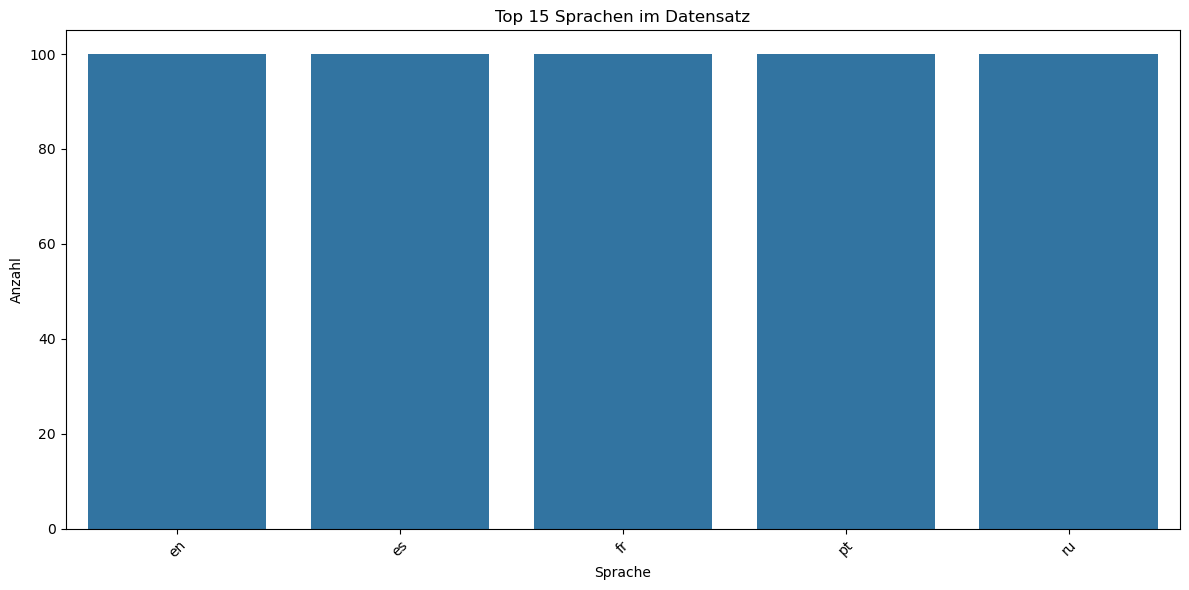

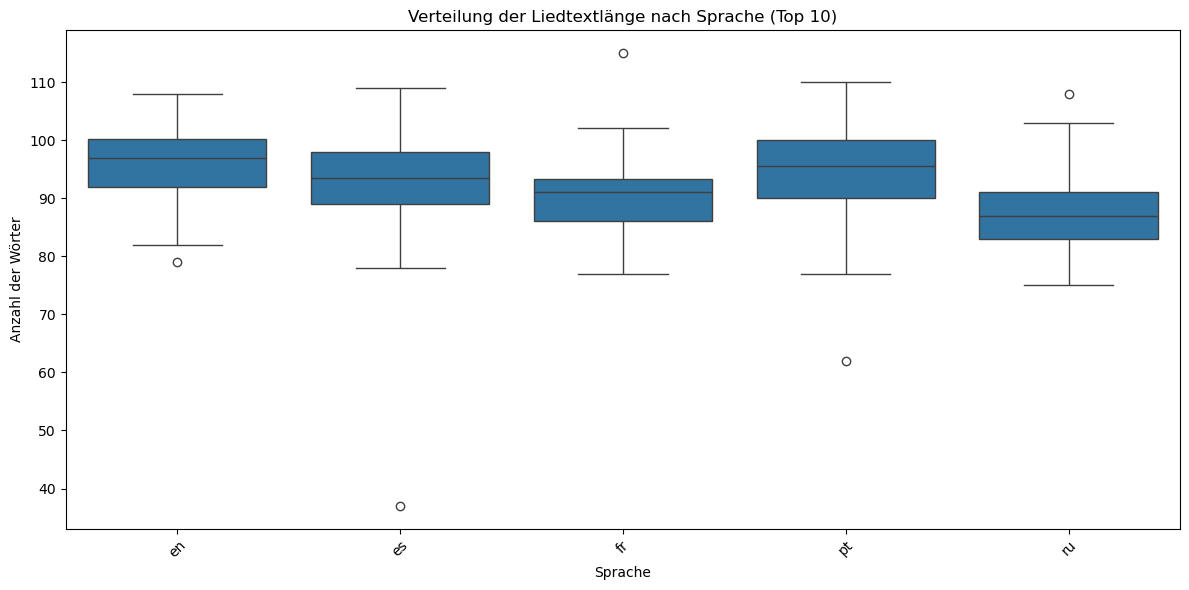

In [52]:
# Häufigkeitsverteilung der erkannten Sprachen
plt.figure(figsize=(12, 6))
lang_counts = df['language'].value_counts().head(15)
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title('Top 15 Sprachen im Datensatz')
plt.xlabel('Sprache')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Liedtextlänge nach Sprache
df['lyrics_length'] = df['lyrics'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

plt.figure(figsize=(12, 6))
lang_top10 = df['language'].value_counts().head(10).index
df_top_langs = df[df['language'].isin(lang_top10)]

sns.boxplot(x='language', y='lyrics_length', data=df_top_langs)
plt.title('Verteilung der Liedtextlänge nach Sprache (Top 10)')
plt.xlabel('Sprache')
plt.ylabel('Anzahl der Wörter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


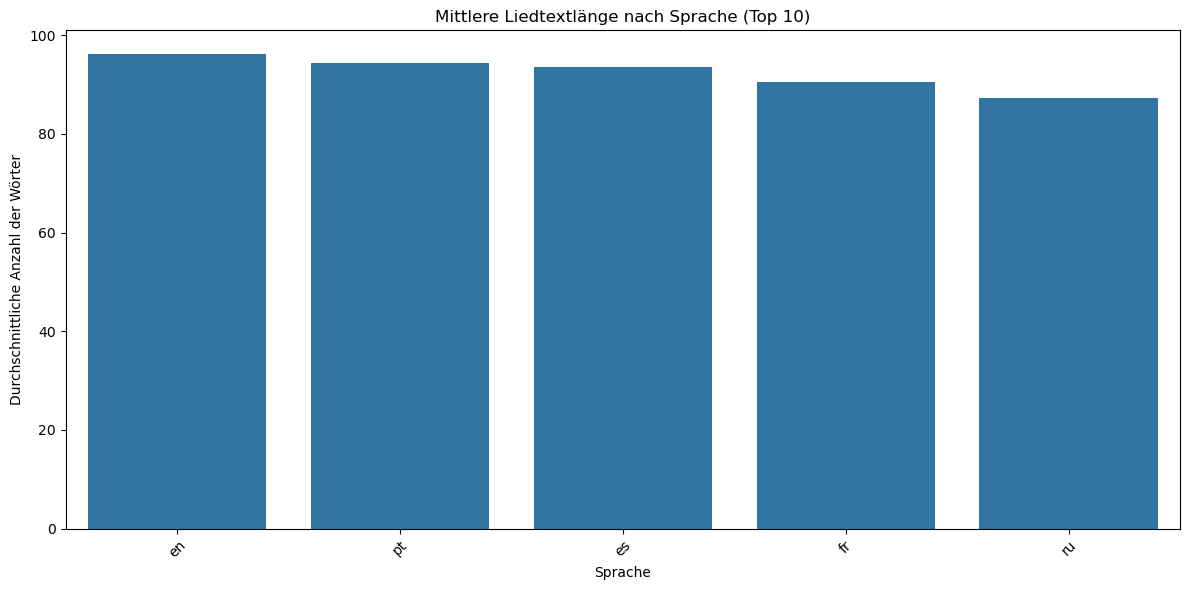

In [53]:
# Mittlere Liedtextlänge nach Sprache
lang_length = df.groupby('language')['lyrics_length'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_length.index, y=lang_length.values)
plt.title('Mittlere Liedtextlänge nach Sprache (Top 10)')
plt.xlabel('Sprache')
plt.ylabel('Durchschnittliche Anzahl der Wörter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

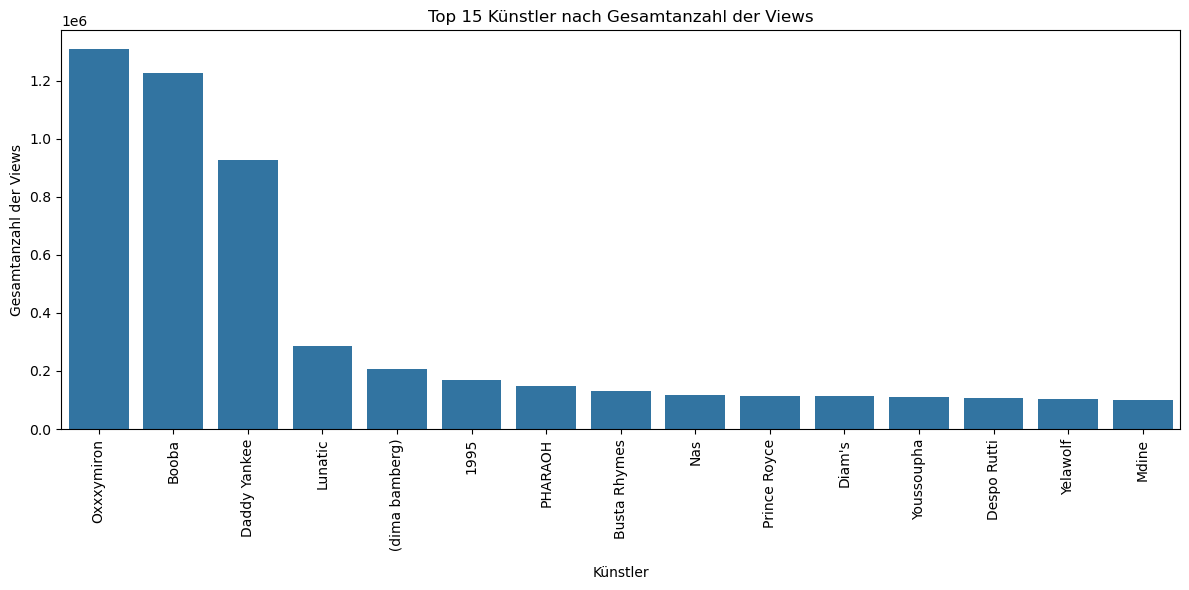

In [54]:
# Top Künstler nach Anzahl der Views
top_artists = df.groupby('artist')['views'].sum().sort_values(ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top 15 Künstler nach Gesamtanzahl der Views')
plt.xlabel('Künstler')
plt.ylabel('Gesamtanzahl der Views')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

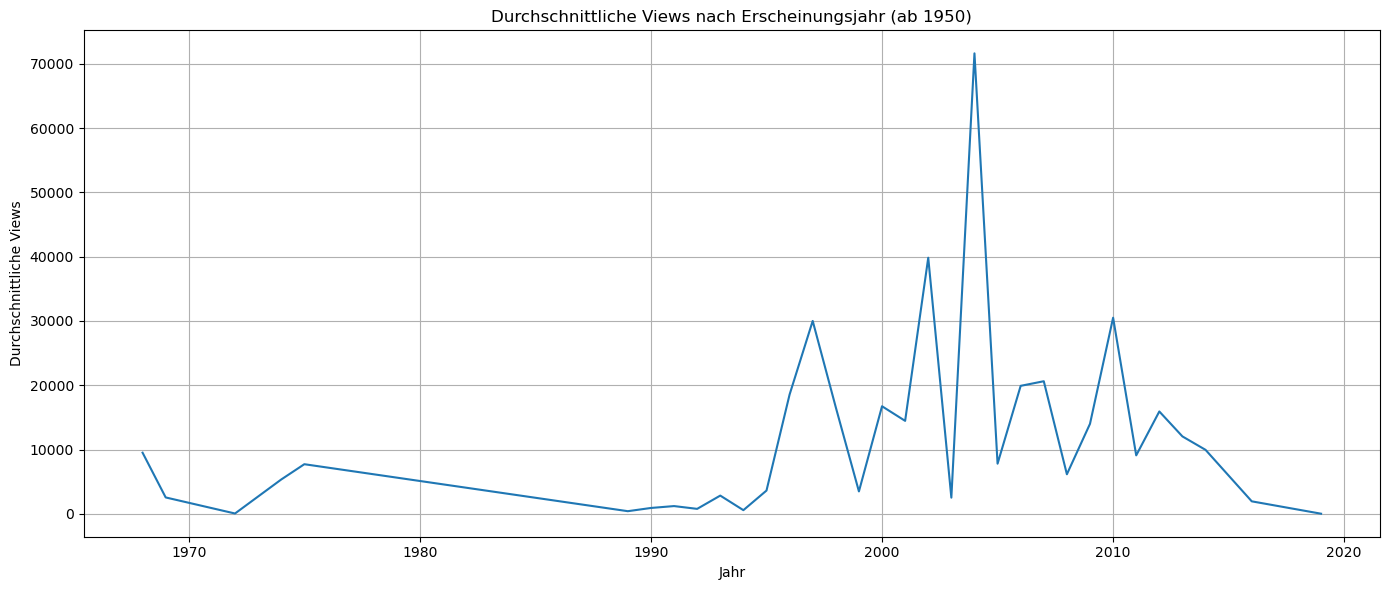

In [55]:
# Zusammenhang zwischen Erscheinungsjahr und Beliebtheit
# Zunächst Daten nach Jahren gruppieren
year_views = df.groupby('year')['views'].mean().reset_index()
year_views = year_views[year_views['year'] >= 1950]  # Fokus auf die moderne Ära

plt.figure(figsize=(14, 6))
sns.lineplot(x='year', y='views', data=year_views)
plt.title('Durchschnittliche Views nach Erscheinungsjahr (ab 1950)')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche Views')
plt.grid(True)
plt.tight_layout()
plt.show()

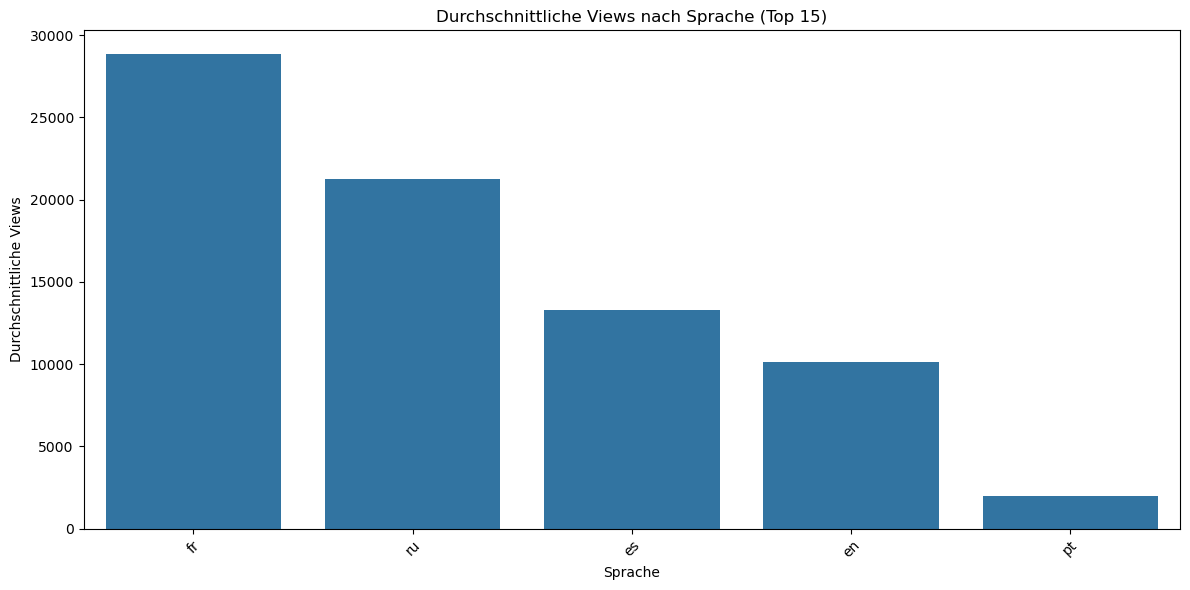

In [56]:
# Zusammenhang zwischen Sprache und Beliebtheit
lang_views = df.groupby('language')['views'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_views.index, y=lang_views.values)
plt.title('Durchschnittliche Views nach Sprache (Top 15)')
plt.xlabel('Sprache')
plt.ylabel('Durchschnittliche Views')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

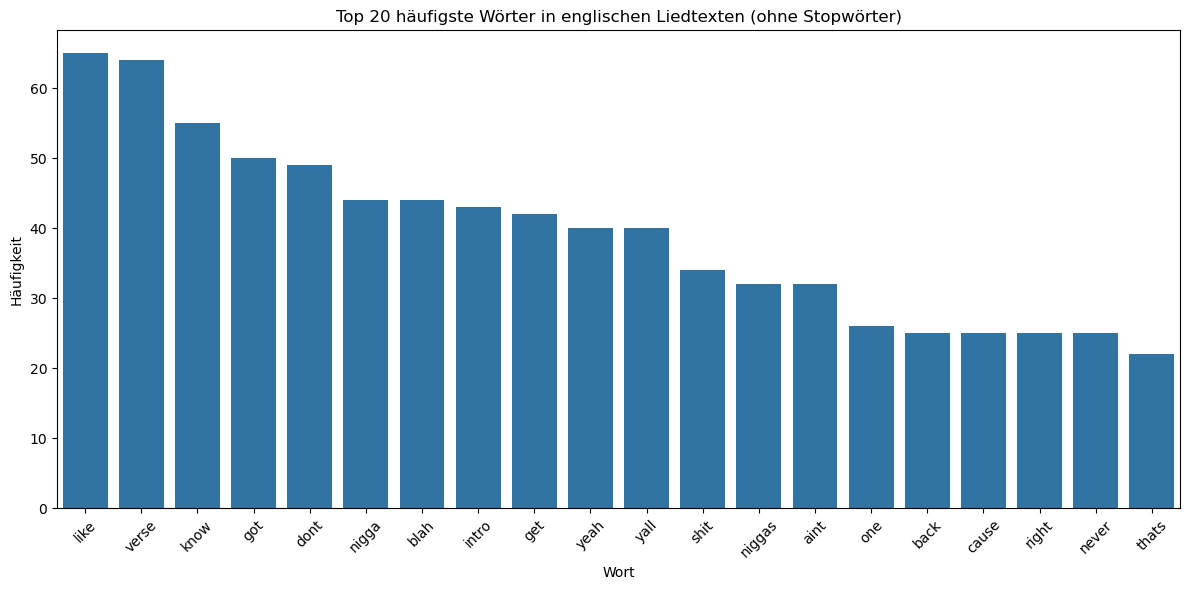

In [57]:
### Analyse der Liedtexte
# Funktion zur Bereinigung von Texten
def clean_text(text):
    if pd.isna(text):
        return ""
    # Text in Kleinbuchstaben umwandeln und Sonderzeichen entfernen
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# Häufigste Wörter (Englisch)
english_lyrics = df[df['language'] == 'en']['lyrics'].apply(clean_text)
english_words = ' '.join(english_lyrics).split()
english_word_counts = Counter(english_words)

# Stopwörter entfernen
english_stopwords = set(stopwords.words('english'))
english_word_counts_no_stopwords = {word: count for word, count in english_word_counts.items() 
                                   if word not in english_stopwords and len(word) > 2}

# Top 20 englische Wörter visualisieren
top_en_words = dict(sorted(english_word_counts_no_stopwords.items(), key=lambda x: x[1], reverse=True)[:20])
plt.figure(figsize=(12, 6))
sns.barplot(x=list(top_en_words.keys()), y=list(top_en_words.values()))
plt.title('Top 20 häufigste Wörter in englischen Liedtexten (ohne Stopwörter)')
plt.xlabel('Wort')
plt.ylabel('Häufigkeit')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

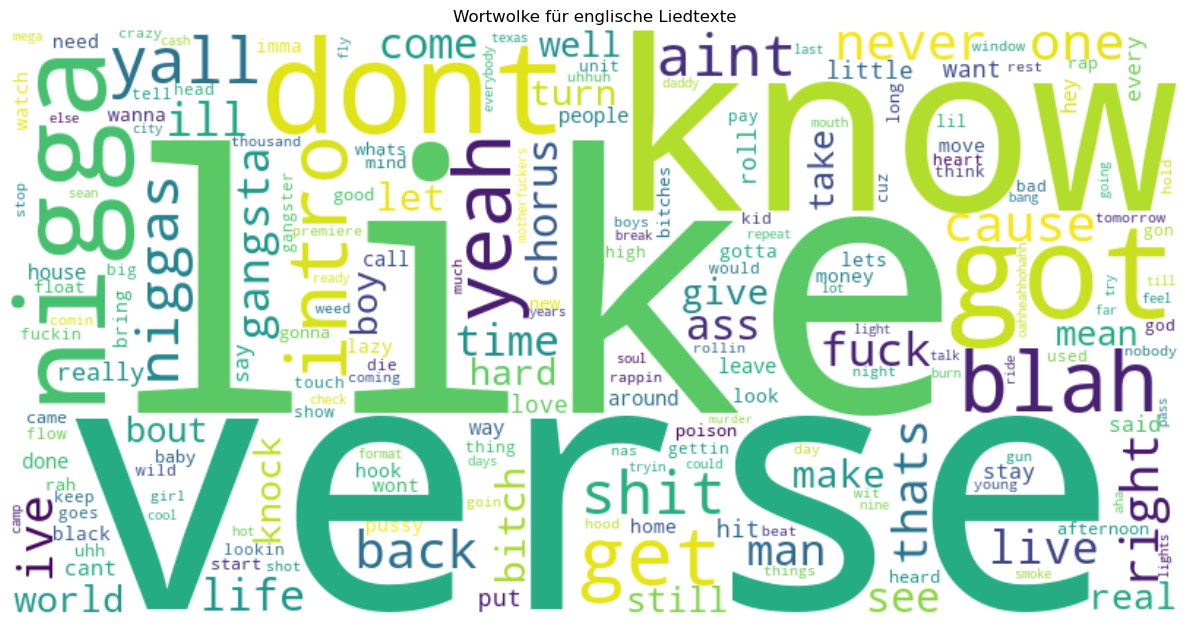

In [58]:
# Wortwolke für englische Texte erstellen
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=200, colormap='viridis').generate_from_frequencies(english_word_counts_no_stopwords)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wortwolke für englische Liedtexte')
plt.tight_layout()
plt.show()

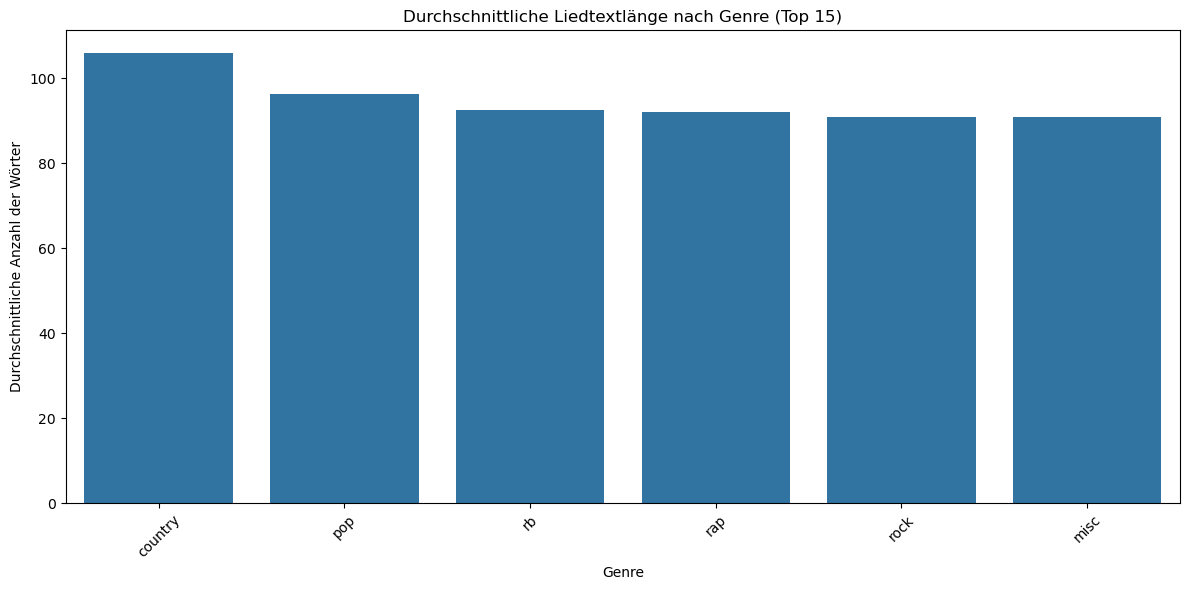

In [59]:
# Durchschnittliche Textlänge nach Genre (Tag)
genre_text_length = df.groupby('tag')['lyrics_length'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_text_length.index, y=genre_text_length.values)
plt.title('Durchschnittliche Liedtextlänge nach Genre (Top 15)')
plt.xlabel('Genre')
plt.ylabel('Durchschnittliche Anzahl der Wörter')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

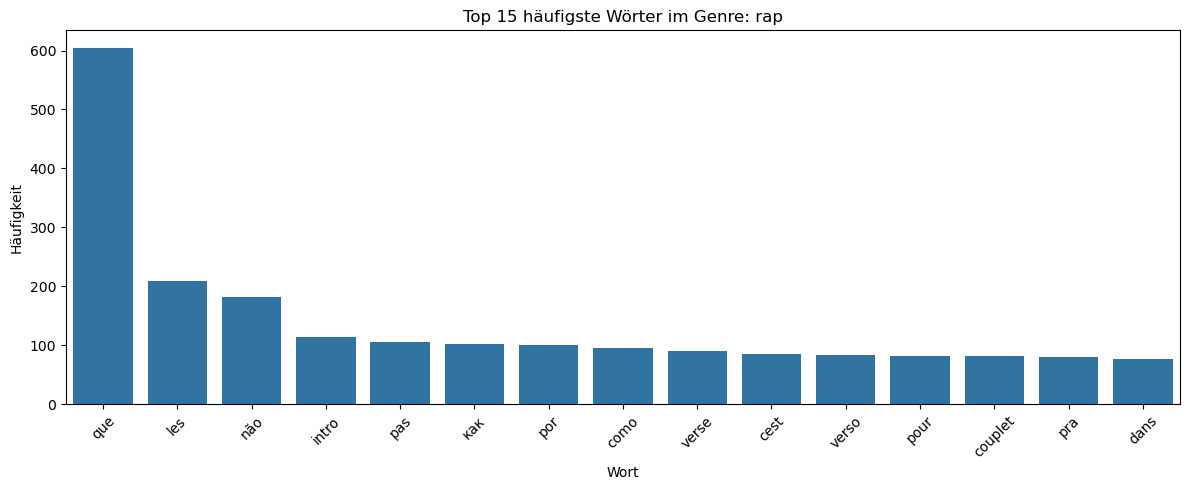

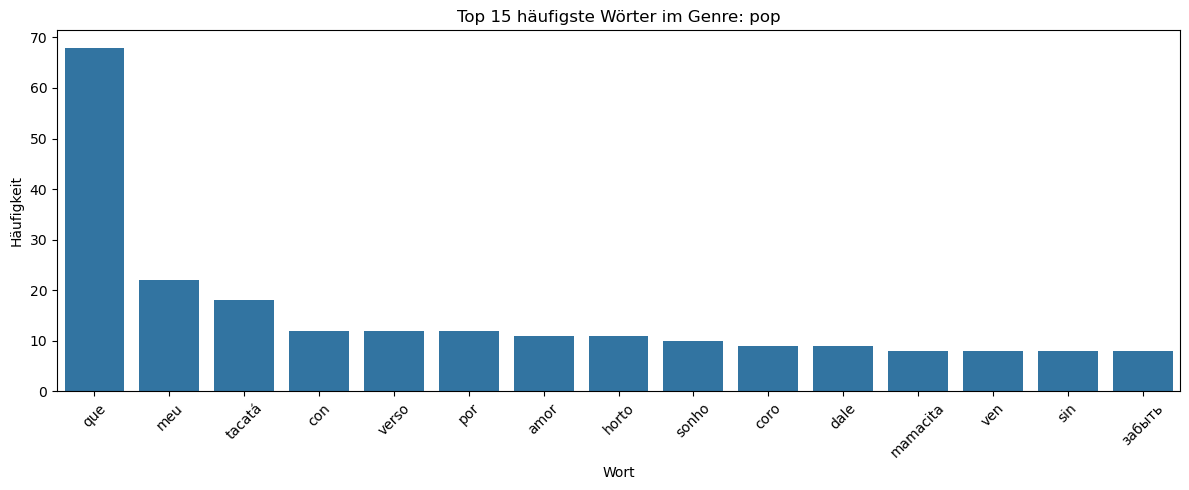

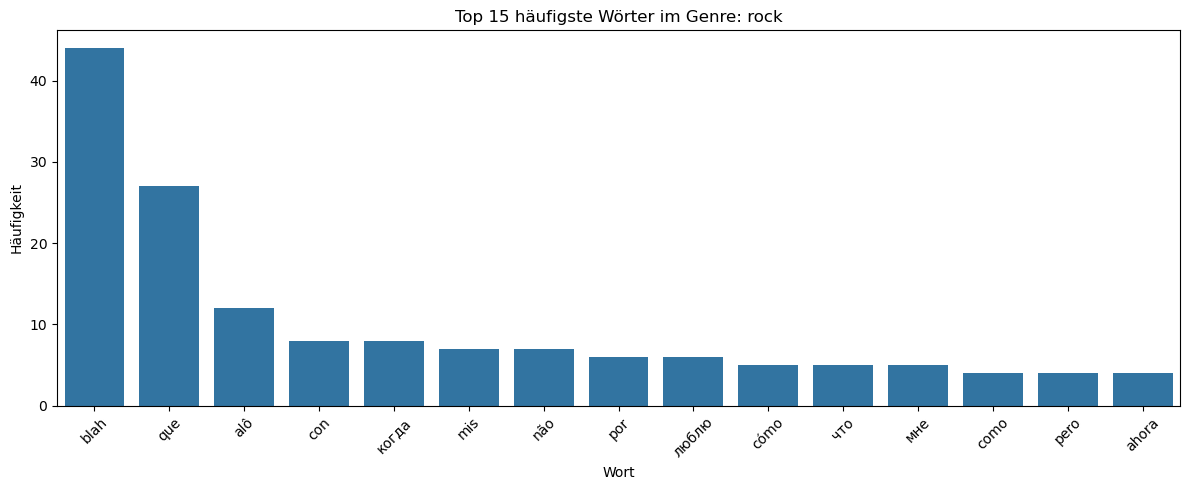

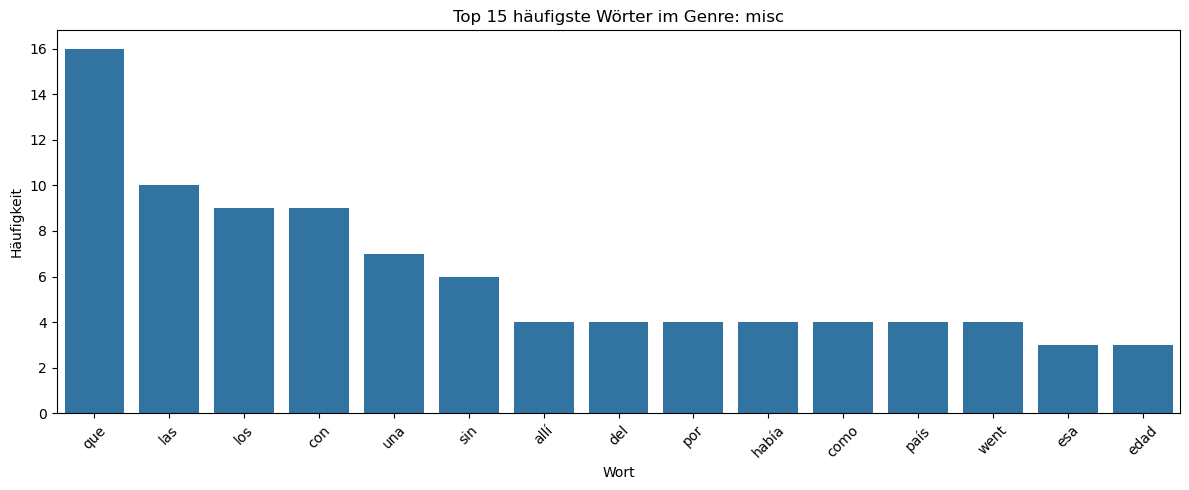

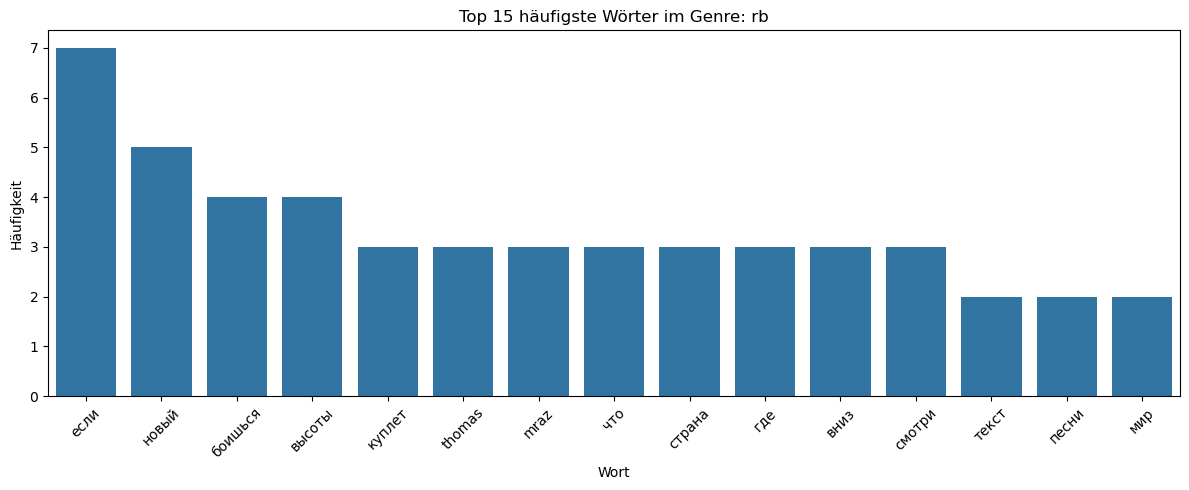

In [60]:
# Wortfrequenz nach Genre für die Top-Genres
top_genres = df['tag'].value_counts().head(5).index
for genre in top_genres:
    # Liedtexte für dieses Genre extrahieren und bereinigen
    genre_lyrics = df[df['tag'] == genre]['lyrics'].apply(clean_text)
    genre_words = ' '.join(genre_lyrics).split()
    genre_word_counts = Counter(genre_words)
    
    # Stopwörter entfernen
    genre_word_counts_no_stopwords = {word: count for word, count in genre_word_counts.items() 
                                     if word not in english_stopwords and len(word) > 2}
    
    # Top 15 Wörter für dieses Genre
    top_genre_words = dict(sorted(genre_word_counts_no_stopwords.items(), key=lambda x: x[1], reverse=True)[:15])
    
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(top_genre_words.keys()), y=list(top_genre_words.values()))
    plt.title(f'Top 15 häufigste Wörter im Genre: {genre}')
    plt.xlabel('Wort')
    plt.ylabel('Häufigkeit')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# MLDM Part


Lineare Regression für Beliebtheitsvorhersage:
RMSE: 10.2294
R²: -22.1331

Ridge Regression für Beliebtheitsvorhersage:
RMSE: 1.9244
R²: 0.1813


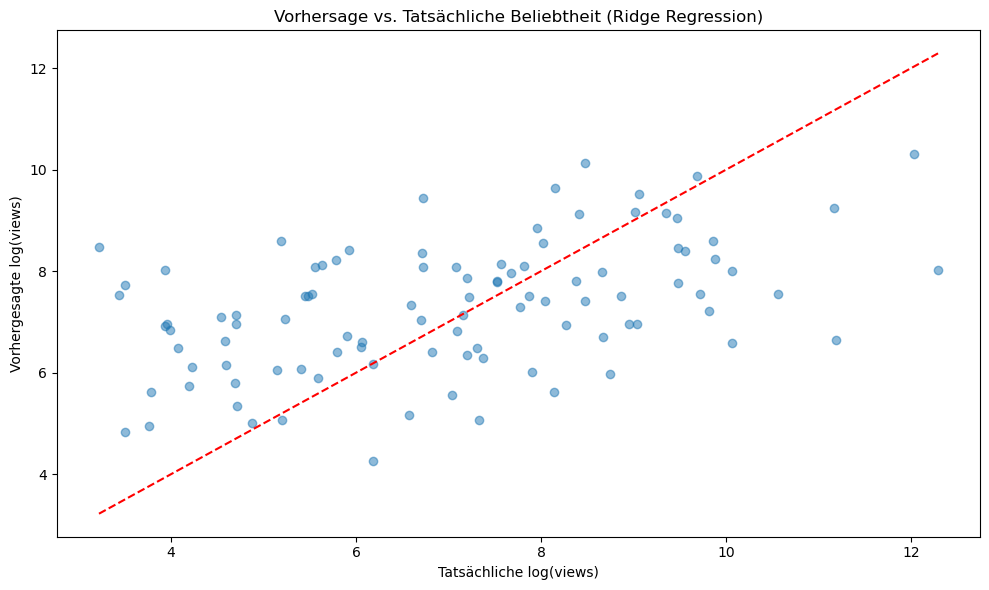

In [64]:
### Beliebtheitsvorhersage (Views)
# Vorbereitung der Daten für die Beliebtheitsvorhersage
popularity_df = ml_df.dropna(subset=['views', 'year']).copy()

# Log-Transformation der Views (typischerweise sehr schiefe Verteilung)
popularity_df['log_views'] = np.log1p(popularity_df['views'])

# Feature-Extraktion
# Wir verwenden Jahr als numerisches Feature
popularity_df['year'] = popularity_df['year'].astype(float)

# Label-Encoding für Künstler
artist_encoder = LabelEncoder()
popularity_df['artist_encoded'] = artist_encoder.fit_transform(popularity_df['artist'])

# TF-IDF für Liedtexte (mit weniger Features für Performance)
tfidf_pop = TfidfVectorizer(max_features=2000, min_df=10)
lyrics_features = tfidf_pop.fit_transform(popularity_df['cleaned_lyrics'])

# Erstellen einer Feature-Matrix
# Wir kombinieren Textmerkmale mit Jahr und Künstler
from scipy.sparse import hstack
X_features = hstack([
    lyrics_features,
    popularity_df[['year', 'artist_encoded']].to_numpy()
])

# Zielvariable
y_views = popularity_df['log_views'].values

# Aufteilung in Trainings- und Testdaten
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(
    X_features, y_views, test_size=0.2, random_state=42
)

# 1. Lineare Regression
lr_model = LinearRegression()
lr_model.fit(X_train_pop, y_train_pop)
lr_predictions = lr_model.predict(X_test_pop)

# 2. Ridge Regression (regulierte Regression)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_pop, y_train_pop)
ridge_predictions = ridge_model.predict(X_test_pop)

# Modellbewertung
print("Lineare Regression für Beliebtheitsvorhersage:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_pop, lr_predictions)):.4f}")
print(f"R²: {r2_score(y_test_pop, lr_predictions):.4f}")

print("\nRidge Regression für Beliebtheitsvorhersage:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_pop, ridge_predictions)):.4f}")
print(f"R²: {r2_score(y_test_pop, ridge_predictions):.4f}")

# Visualisierung der Vorhersagen vs. tatsächliche Werte
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pop, ridge_predictions, alpha=0.5)
plt.plot([y_test_pop.min(), y_test_pop.max()], [y_test_pop.min(), y_test_pop.max()], 'r--')
plt.xlabel('Tatsächliche log(views)')
plt.ylabel('Vorhergesagte log(views)')
plt.title('Vorhersage vs. Tatsächliche Beliebtheit (Ridge Regression)')
plt.tight_layout()
plt.show()

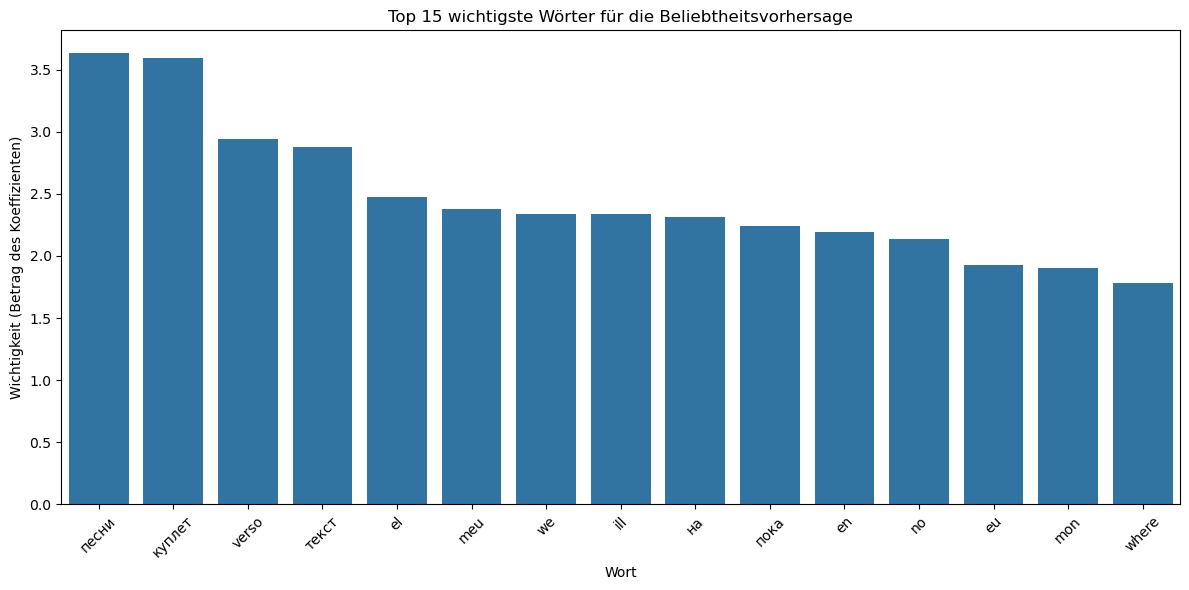

In [65]:
# Feature-Importance für die Beliebtheit (basierend auf den Ridge-Koeffizienten für die TF-IDF-Features)
tfidf_feature_names = tfidf_pop.get_feature_names_out()
tfidf_coefs = ridge_model.coef_[:len(tfidf_feature_names)]

# Top-15 wichtigste Wörter
word_importance = pd.DataFrame({
    'word': tfidf_feature_names,
    'importance': np.abs(tfidf_coefs)
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='importance', data=word_importance)
plt.title('Top 15 wichtigste Wörter für die Beliebtheitsvorhersage')
plt.xlabel('Wort')
plt.ylabel('Wichtigkeit (Betrag des Koeffizienten)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Naive Bayes für Spracherkennung:
Genauigkeit: 1.0000
              precision    recall  f1-score   support

          en       1.00      1.00      1.00        20
          es       1.00      1.00      1.00        20
          fr       1.00      1.00      1.00        20
          pt       1.00      1.00      1.00        20
          ru       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



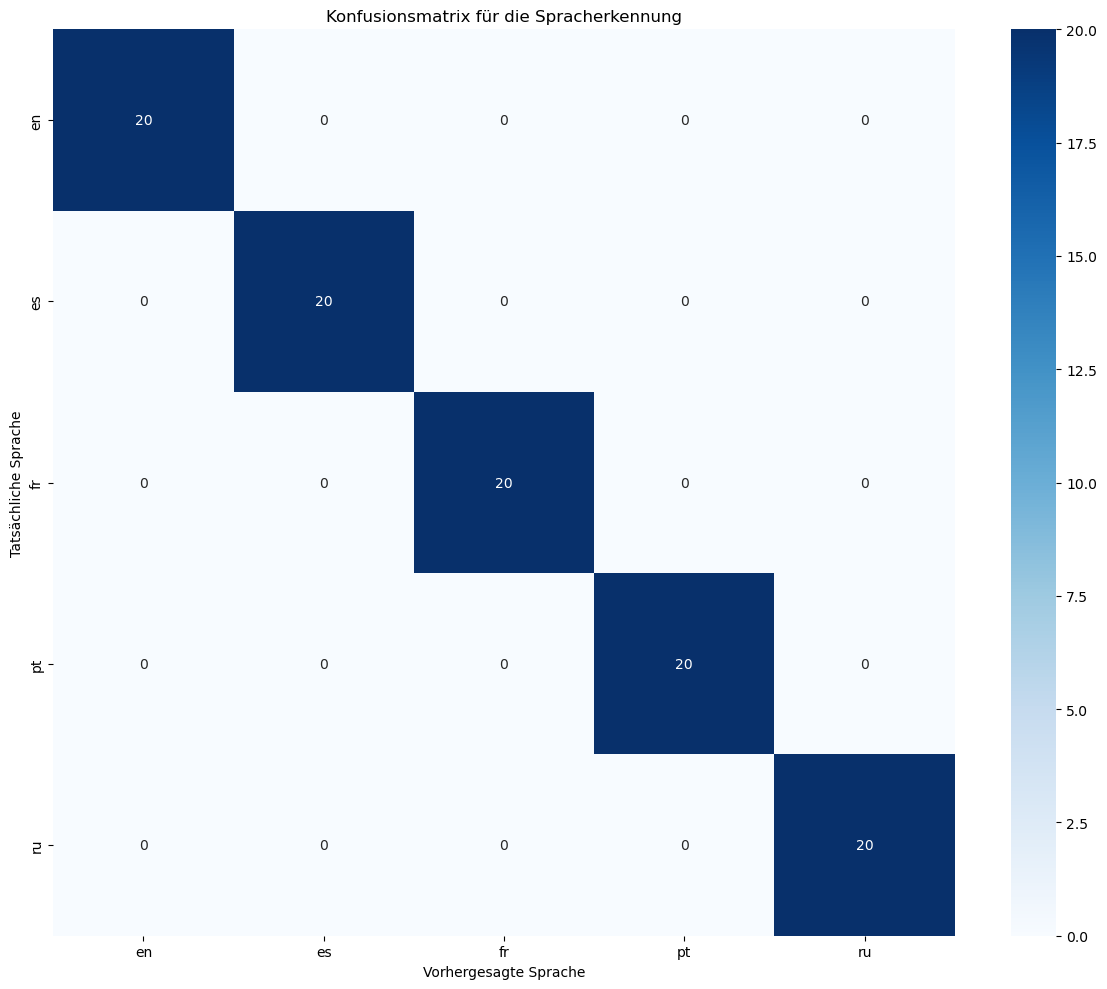

In [66]:
# Vorbereitung der Daten für die Spracherkennung
# Wir nehmen nur Einträge mit bekannter Sprache
lang_df = df.dropna(subset=['language', 'lyrics']).copy()

# Top 10 häufigste Sprachen für bessere Klassifikation
top_languages = lang_df['language'].value_counts().head(10).index
lang_df = lang_df[lang_df['language'].isin(top_languages)].copy()

# Label-Encoder für Sprachen
lang_encoder = LabelEncoder()
lang_df['language_encoded'] = lang_encoder.fit_transform(lang_df['language'])

# Feature-Extraktion - wir verwenden Character-level n-Gramme (gut für Sprachmerkmale)
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), max_features=5000)
X_lang = char_vectorizer.fit_transform(lang_df['cleaned_lyrics'])
y_lang = lang_df['language_encoded']

# Aufteilung in Trainings- und Testdaten
X_train_lang, X_test_lang, y_train_lang, y_test_lang = train_test_split(
    X_lang, y_lang, test_size=0.2, random_state=42, stratify=y_lang
)

# Naive Bayes für Spracherkennung (oft sehr effektiv für diese Aufgabe)
nb_lang_model = MultinomialNB()
nb_lang_model.fit(X_train_lang, y_train_lang)
nb_lang_predictions = nb_lang_model.predict(X_test_lang)

# Modellbewertung
print("Naive Bayes für Spracherkennung:")
print(f"Genauigkeit: {accuracy_score(y_test_lang, nb_lang_predictions):.4f}")
print(classification_report(y_test_lang, nb_lang_predictions, target_names=lang_encoder.classes_))

# Konfusionsmatrix für die Spracherkennung
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_lang, nb_lang_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=lang_encoder.classes_,
           yticklabels=lang_encoder.classes_)
plt.title('Konfusionsmatrix für die Spracherkennung')
plt.xlabel('Vorhergesagte Sprache')
plt.ylabel('Tatsächliche Sprache')
plt.tight_layout()
plt.show()

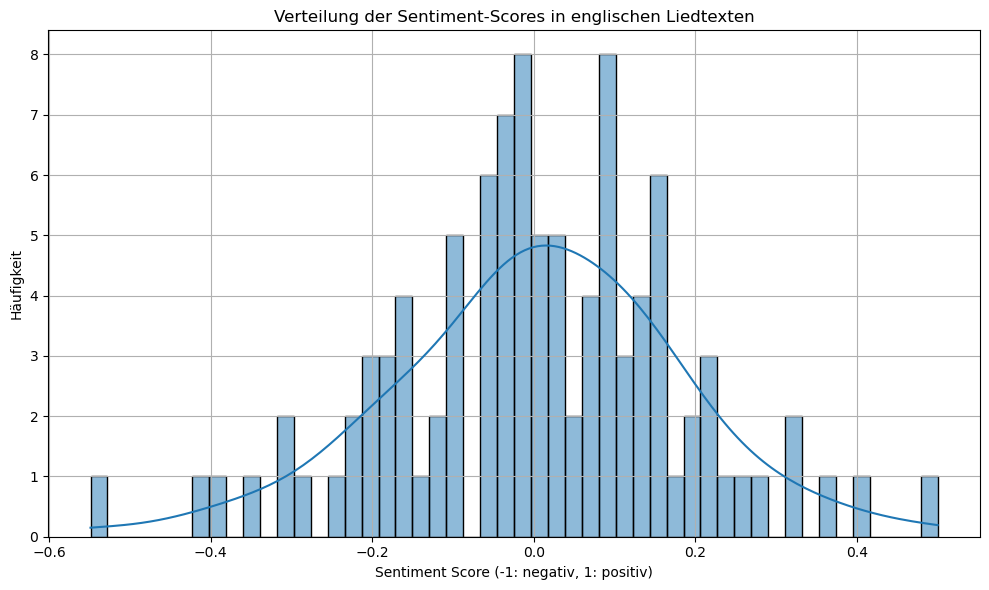

In [67]:
### Sentiment-Analyse

# Sentiment-Analyse für englische Texte
# Wir verwenden TextBlob für eine einfache Sentiment-Analyse

def get_sentiment(text):
    if pd.isna(text):
        return np.nan
    # TextBlob für Sentiment-Analyse verwenden
    analysis = TextBlob(str(text))
    # Polarität: -1 (sehr negativ) bis 1 (sehr positiv)
    return analysis.sentiment.polarity

# Sentiment für englische Texte berechnen
english_df['sentiment'] = english_df['lyrics'].apply(get_sentiment)

# Verteilung der Sentiments
plt.figure(figsize=(10, 6))
sns.histplot(english_df['sentiment'], bins=50, kde=True)
plt.title('Verteilung der Sentiment-Scores in englischen Liedtexten')
plt.xlabel('Sentiment Score (-1: negativ, 1: positiv)')
plt.ylabel('Häufigkeit')
plt.grid(True)
plt.tight_layout()
plt.show()

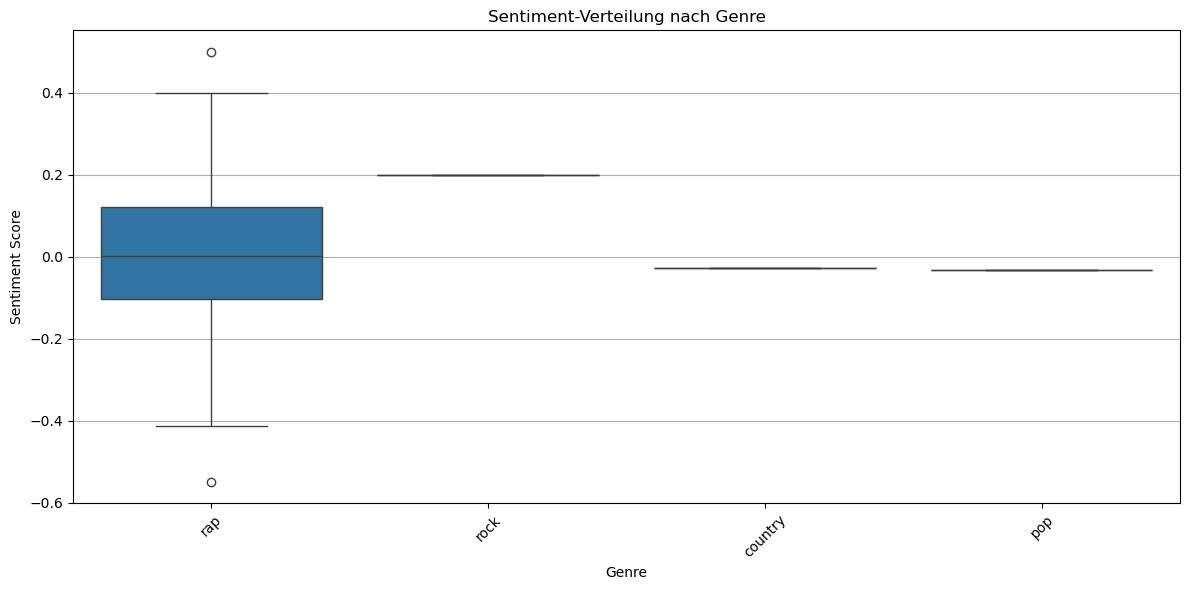

In [68]:
# Sentiment nach Genre für die Top-10 Genres
top10_genres = english_df['tag'].value_counts().head(10).index
genre_sentiment = english_df[english_df['tag'].isin(top10_genres)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='tag', y='sentiment', data=genre_sentiment)
plt.title('Sentiment-Verteilung nach Genre')
plt.xlabel('Genre')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

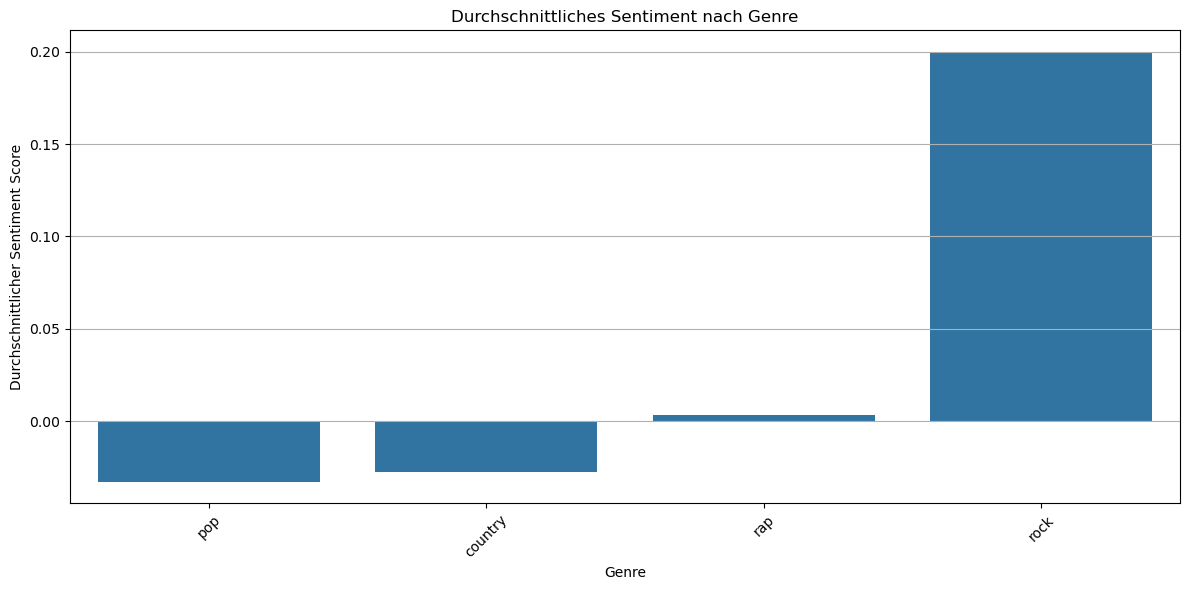

In [69]:
# Durchschnittliches Sentiment nach Genre
avg_sentiment = genre_sentiment.groupby('tag')['sentiment'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Durchschnittliches Sentiment nach Genre')
plt.xlabel('Genre')
plt.ylabel('Durchschnittlicher Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

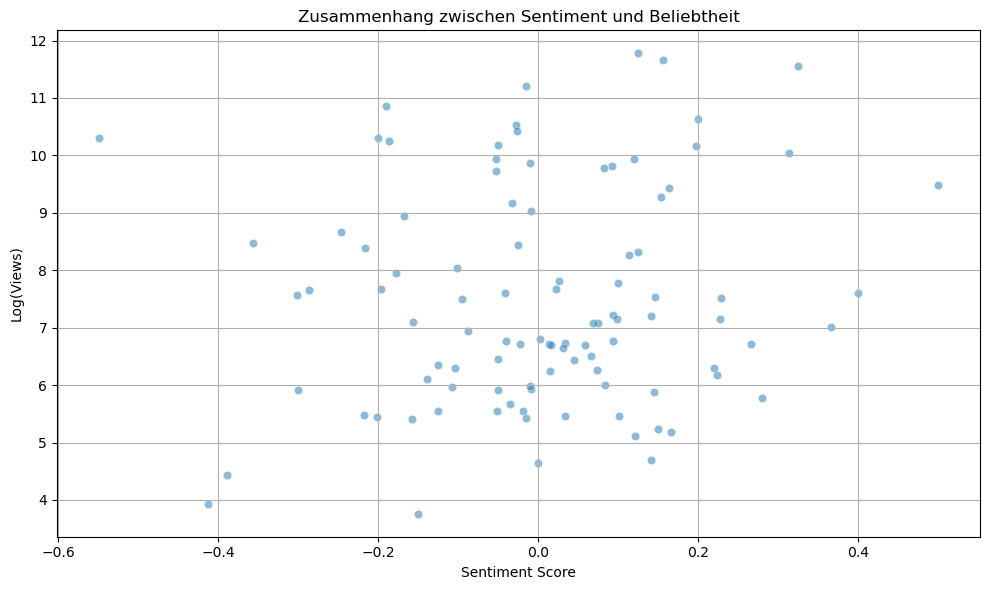

In [70]:
# Sentiment und Beliebtheit
plt.figure(figsize=(10, 6))
# Log-Transformation der Views für bessere Visualisierung
english_df['log_views'] = np.log1p(english_df['views'])
sns.scatterplot(x='sentiment', y='log_views', data=english_df, alpha=0.5)
plt.title('Zusammenhang zwischen Sentiment und Beliebtheit')
plt.xlabel('Sentiment Score')
plt.ylabel('Log(Views)')
plt.grid(True)
plt.tight_layout()
plt.show()

Thema #1: verse little intro people chorus got man let come like
Thema #2: got live like verse bitch nigga im em real fuck
Thema #3: home time know make like im yeah ive bad right
Thema #4: ha verse just intro cause yeah uh know everybody im
Thema #5: im nigga niggas like know dont yo shit come verse
Thema #6: know aint yeah hard dont leave im shit yall cause
Thema #7: just yall like im dont thats mean yeah uh verse
Thema #8: ive im nigga life boy aint verse house intro whats
Thema #9: im ill yeah rap time like dont black verse shot
Thema #10: world just dont im hard far verse shit wanna thing


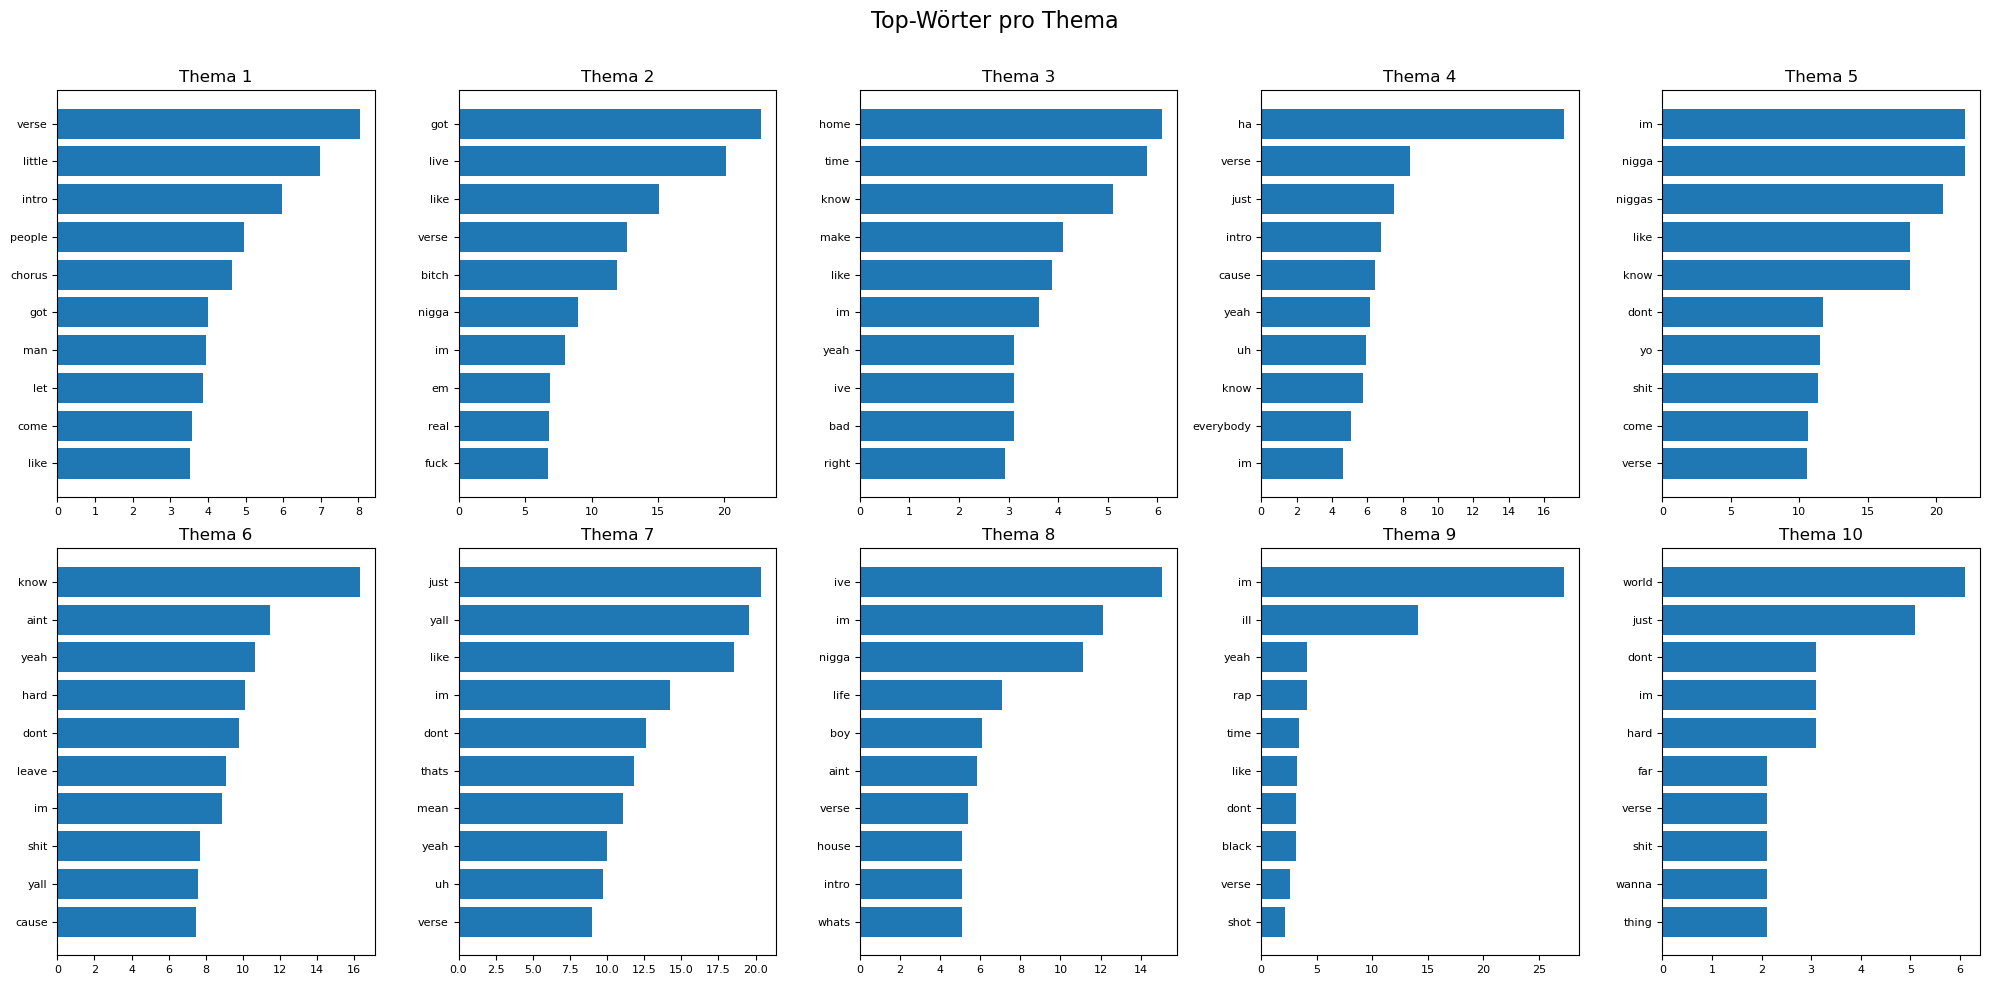

In [71]:
## Themenmodellierung (Topic Modeling)
# Themenmodellierung mit Latent Dirichlet Allocation (LDA)
# Wir beschränken uns auf englische Texte

# Vorbereitung der Texte
vectorizer = CountVectorizer(max_features=5000, min_df=5, stop_words='english')
X_topics = vectorizer.fit_transform(english_df['cleaned_lyrics'])

# LDA-Modell trainieren
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_model.fit(X_topics)

# Top-Wörter für jedes Thema ausgeben
feature_names = vectorizer.get_feature_names_out()

# Funktion zum Anzeigen der Top-Wörter pro Thema
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append((topic_idx, ' '.join(top_words)))
    return topics

# Top 10 Wörter für jedes Thema
topics = display_topics(lda_model, feature_names, 10)
for topic_idx, top_words in topics:
    print(f"Thema #{topic_idx+1}: {top_words}")

# Visualisierung der Top-Wörter für jedes Thema
n_top_words = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = [topic[i] for i in top_words_idx]
    
    ax = axes[topic_idx]
    ax.barh(top_words, top_weights)
    ax.set_title(f'Thema {topic_idx + 1}')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=8)
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.suptitle('Top-Wörter pro Thema', fontsize=16)
plt.show()

## NLP W1 Euclidean Distance, Manhatten Distance and Generalizations, Cosine Similarity, Word Embeddings

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaschambeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
file_path = '/Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/reduced/lyrics_minimal.csv'
df = pd.read_csv(file_path)
print(f"Datensatz geladen: {df.shape[0]} Zeilen und {df.shape[1]} Spalten")

english_df = df[df['language'] == 'en'].copy()
print(f"Englische Texte: {english_df.shape[0]}")

Datensatz geladen: 500 Zeilen und 11 Spalten
Englische Texte: 100


In [74]:
def clean_text(text):
    if pd.isna(text):
        return ""
    return re.sub(r'[^\w\s]', '', str(text).lower())

english_df['cleaned_lyrics'] = english_df['lyrics'].apply(clean_text)


In [77]:
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Prüfe, ob die Daten bereits heruntergeladen wurden
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    # Lege ein spezifisches Verzeichnis für NLTK-Daten fest
    nltk_data_dir = os.path.expanduser('~/nltk_data')
    os.makedirs(nltk_data_dir, exist_ok=True)
    
    # Lade die Daten in das spezifische Verzeichnis
    nltk.download('punkt', download_dir=nltk_data_dir)
    nltk.download('stopwords', download_dir=nltk_data_dir)

# Stelle sicher, dass NLTK weiß, wo es nach den Daten suchen soll
nltk.data.path.append(os.path.expanduser('~/nltk_data'))

# Definiere die Tokenisierungsfunktion
def tokenize_text(text):
    if pd.isna(text):
        return []
    
    # Stopwörter laden
    try:
        stop_words = set(stopwords.words('english'))
    except LookupError:
        # Fallback, falls stopwords nicht geladen werden können
        stop_words = set()
        print("Warnung: Stopwörter konnten nicht geladen werden.")
    
    # Tokenisieren und bereinigen
    try:
        tokens = word_tokenize(str(text).lower())
    except LookupError:
        # Fallback, falls tokenizer nicht geladen werden kann
        tokens = str(text).lower().split()
        print("Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.")
    
    # Entfernen von Sonderzeichen und Stopwörtern
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]
    return tokens

# Tokenisierung anwenden
english_df['tokens'] = english_df['cleaned_lyrics'].apply(tokenize_text)

Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende einfache Tokensierung.
Warnung: Punkt tokenizer nicht gefunden, verwende e

In [78]:
sample_size = 1000
english_sample = english_df.sample(min(sample_size, len(english_df)), random_state=42)
print("Datenaufbereitung abgeschlossen.")

Datenaufbereitung abgeschlossen.


In [79]:
def compute_tfidf(texts, max_features=1000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    return tfidf_matrix, tfidf_vectorizer

small_sample = english_sample.head(100)
tfidf_matrix, tfidf_vectorizer = compute_tfidf(small_sample['cleaned_lyrics'])
print(f"TF-IDF Matrix erstellt mit Form: {tfidf_matrix.shape}")


TF-IDF Matrix erstellt mit Form: (100, 1000)


In [80]:
euclidean_dist_matrix = euclidean_distances(tfidf_matrix)
manhattan_dist_matrix = manhattan_distances(tfidf_matrix)
cosine_sim_matrix = cosine_similarity(tfidf_matrix)
cosine_dist_matrix = 1 - cosine_sim_matrix


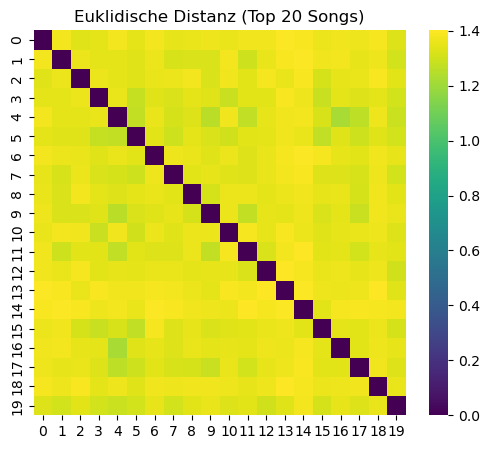

In [81]:
# Euklidisch
plt.figure(figsize=(6, 5))
sns.heatmap(euclidean_dist_matrix[:20, :20], cmap='viridis')
plt.title('Euklidische Distanz (Top 20 Songs)')
plt.show()


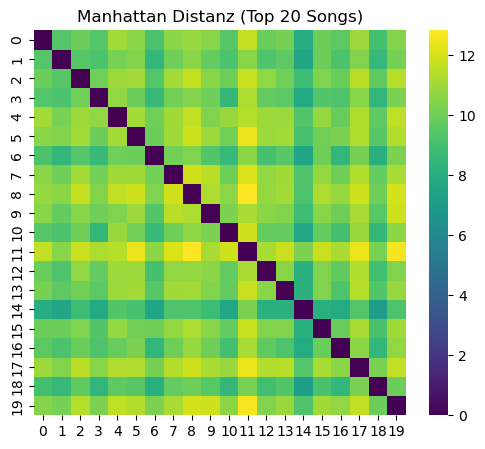

In [82]:
# Manhattan
plt.figure(figsize=(6, 5))
sns.heatmap(manhattan_dist_matrix[:20, :20], cmap='viridis')
plt.title('Manhattan Distanz (Top 20 Songs)')
plt.show()


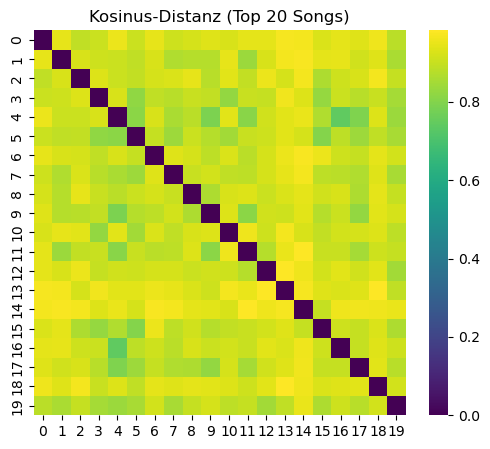

In [83]:
# Kosinus
plt.figure(figsize=(6, 5))
sns.heatmap(cosine_dist_matrix[:20, :20], cmap='viridis')
plt.title('Kosinus-Distanz (Top 20 Songs)')
plt.show()


In [84]:
sentences = [tokens for tokens in english_sample['tokens'] if len(tokens) > 0]
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)
print(f"Word2Vec Modell trainiert mit {len(word2vec_model.wv.key_to_index)} Wörtern.")


Word2Vec Modell trainiert mit 199 Wörtern.


In [85]:
example_words = ['love', 'heart', 'money', 'night', 'pain', 'happy', 'sad']
for word in example_words:
    try:
        similar = word2vec_model.wv.most_similar(word, topn=10)
        print(f"\nÄhnliche Wörter zu '{word}':")
        for w, sim in similar:
            print(f"  {w}: {sim:.4f}")
    except KeyError:
        print(f"'{word}' nicht im Vokabular.")



Ähnliche Wörter zu 'love':
  shit: 0.9974
  verse: 0.9970
  back: 0.9968
  know: 0.9967
  niggas: 0.9965
  get: 0.9965
  right: 0.9964
  hard: 0.9964
  bitch: 0.9964
  like: 0.9963

Ähnliche Wörter zu 'heart':
  one: 0.9964
  verse: 0.9964
  like: 0.9963
  see: 0.9962
  get: 0.9961
  nigga: 0.9960
  shit: 0.9960
  take: 0.9960
  got: 0.9960
  mean: 0.9959

Ähnliche Wörter zu 'money':
  niggas: 0.9972
  get: 0.9971
  know: 0.9970
  dont: 0.9970
  ass: 0.9969
  shit: 0.9967
  hard: 0.9967
  cant: 0.9967
  verse: 0.9967
  nigga: 0.9966

Ähnliche Wörter zu 'night':
  know: 0.9950
  every: 0.9950
  back: 0.9950
  shit: 0.9949
  verse: 0.9949
  get: 0.9948
  real: 0.9948
  ass: 0.9947
  niggas: 0.9946
  hard: 0.9946
'pain' nicht im Vokabular.
'happy' nicht im Vokabular.
'sad' nicht im Vokabular.


In [86]:
def get_song_vector(tokens, model, vector_size=100):
    vec = np.zeros(vector_size)
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word]
            count += 1
        except KeyError:
            continue
    return vec / count if count > 0 else vec

song_vectors = []
valid_indices = []

for i, tokens in enumerate(english_sample['tokens']):
    vec = get_song_vector(tokens, word2vec_model)
    if np.any(vec):
        song_vectors.append(vec)
        valid_indices.append(i)

song_vectors = np.array(song_vectors)
print(f"Song-Vektoren erstellt: {len(song_vectors)}")


Song-Vektoren erstellt: 100


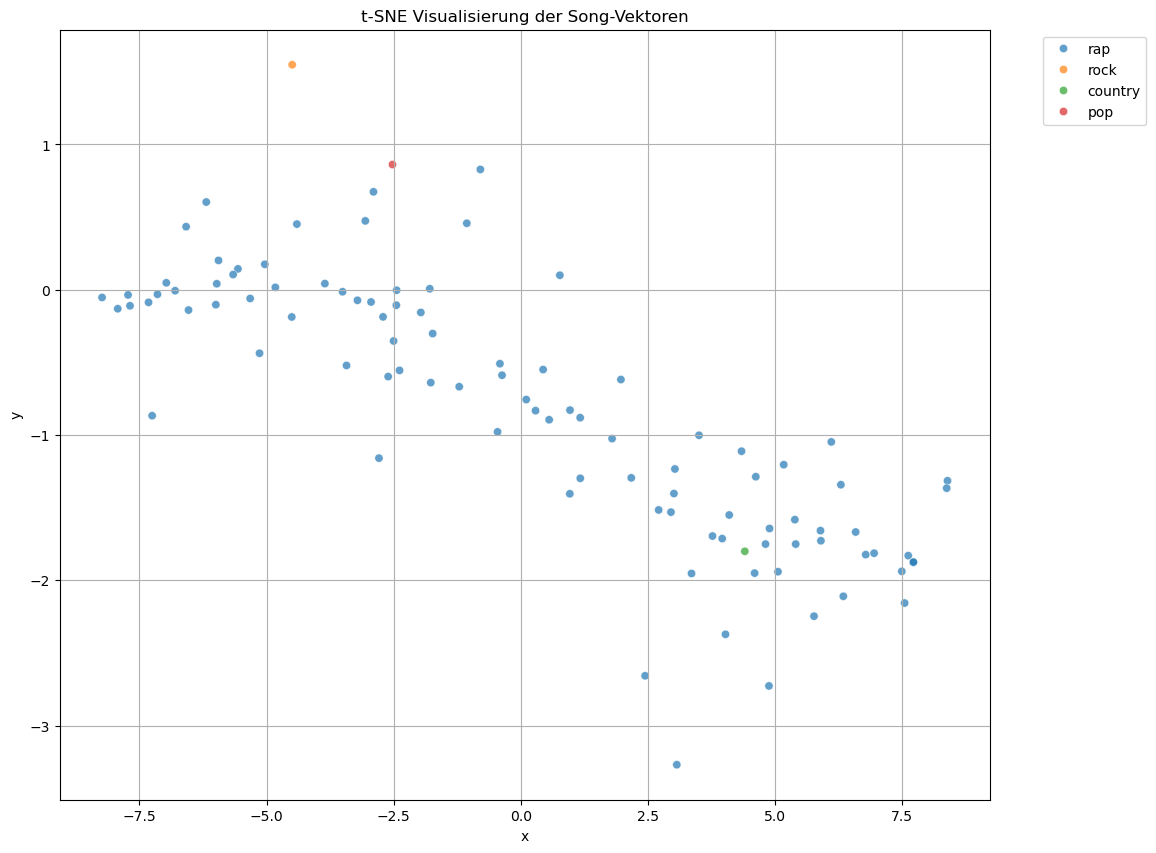

In [87]:
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(song_vectors)-1))
song_vectors_2d = tsne.fit_transform(song_vectors)

songs_df = pd.DataFrame({
    'x': song_vectors_2d[:, 0],
    'y': song_vectors_2d[:, 1],
    'title': english_sample.iloc[valid_indices]['title'].values,
    'artist': english_sample.iloc[valid_indices]['artist'].values,
    'tag': english_sample.iloc[valid_indices]['tag'].values
})

plt.figure(figsize=(12, 10))
sns.scatterplot(data=songs_df, x='x', y='y', hue='tag', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualisierung der Song-Vektoren')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [88]:
normalized_vectors = normalize(song_vectors)
cosine_sim = cosine_similarity(normalized_vectors)

for i in range(min(5, len(valid_indices))):
    idx = valid_indices[i]
    song = english_sample.iloc[idx]
    sim_scores = sorted(list(enumerate(cosine_sim[i])), key=lambda x: x[1], reverse=True)[1:6]
    print(f"\nTop 5 ähnlichste Songs zu '{song['title']}' von {song['artist']}:")
    for j, score in sim_scores:
        similar_song = english_sample.iloc[valid_indices[j]]
        print(f"  '{similar_song['title']}' von {similar_song['artist']} (Ähnlichkeit: {score:.4f})")



Top 5 ähnlichste Songs zu 'Watch Roger Do His Thing' von Main Source:
  'Next Level' von Showbiz & A.G. (Ähnlichkeit: 0.9998)
  'Freaky Behavior' von 2 Live Crew (Ähnlichkeit: 0.9997)
  'She Said' von Mac Miller (Ähnlichkeit: 0.9997)
  'Fat Raps' von King Chip (Ähnlichkeit: 0.9997)
  'Depend on Me' von Mr. Magic (Ähnlichkeit: 0.9997)

Top 5 ähnlichste Songs zu 'Things Got Wild' von U.N.L.V.:
  'Headaches and Woes' von Aceyalone (Ähnlichkeit: 0.9997)
  'Astro' von Kubus (Ähnlichkeit: 0.9996)
  'Daddys Lambo' von Yelawolf (Ähnlichkeit: 0.9996)
  'Relaxation' von Fashawn (Ähnlichkeit: 0.9996)
  'Daddys Home' von Big Daddy Kane (Ähnlichkeit: 0.9996)

Top 5 ähnlichste Songs zu 'Get High to This' von Lil Wyte:
  'Overdose' von Omen (Producer) (Ähnlichkeit: 0.9999)
  'Next Level' von Showbiz & A.G. (Ähnlichkeit: 0.9999)
  'Freaky Behavior' von 2 Live Crew (Ähnlichkeit: 0.9999)
  'Hypnotic' von Syleena Johnson (Ähnlichkeit: 0.9998)
  'Take a Hike One' von Lost Boyz (Ähnlichkeit: 0.9998)

Top 

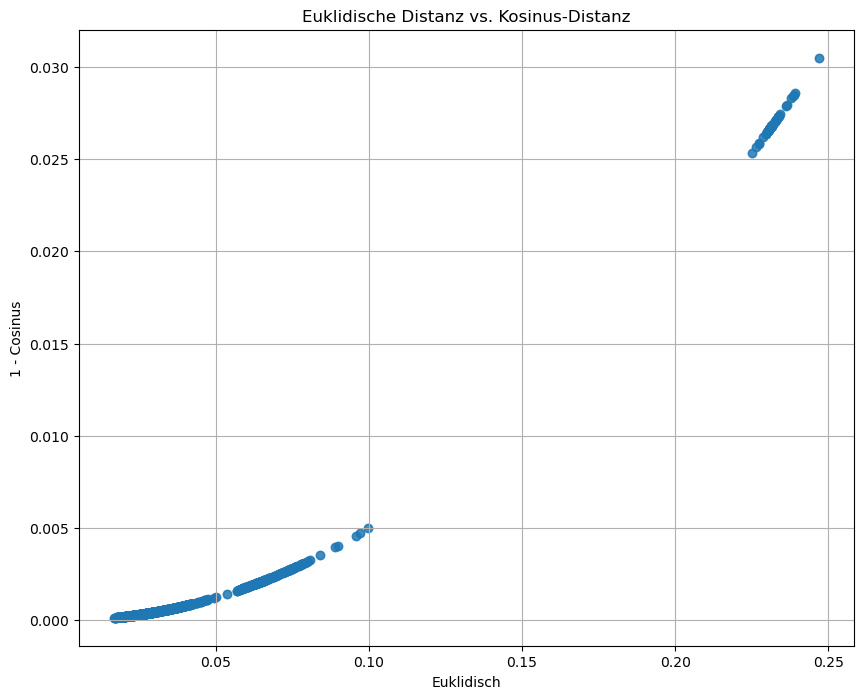

In [89]:
euclidean_dist_normalized = euclidean_distances(normalized_vectors)
subset_size = min(50, len(normalized_vectors))

euc_flat = euclidean_dist_normalized[:subset_size, :subset_size].flatten()
cos_flat = (1 - cosine_sim[:subset_size, :subset_size]).flatten()

mask = ~np.eye(subset_size, dtype=bool).flatten()
euc_flat = euc_flat[mask]
cos_flat = cos_flat[mask]

plt.figure(figsize=(10, 8))
plt.scatter(euc_flat, cos_flat, alpha=0.6)
plt.title('Euklidische Distanz vs. Kosinus-Distanz')
plt.xlabel('Euklidisch')
plt.ylabel('1 - Cosinus')
plt.grid(True)
plt.show()


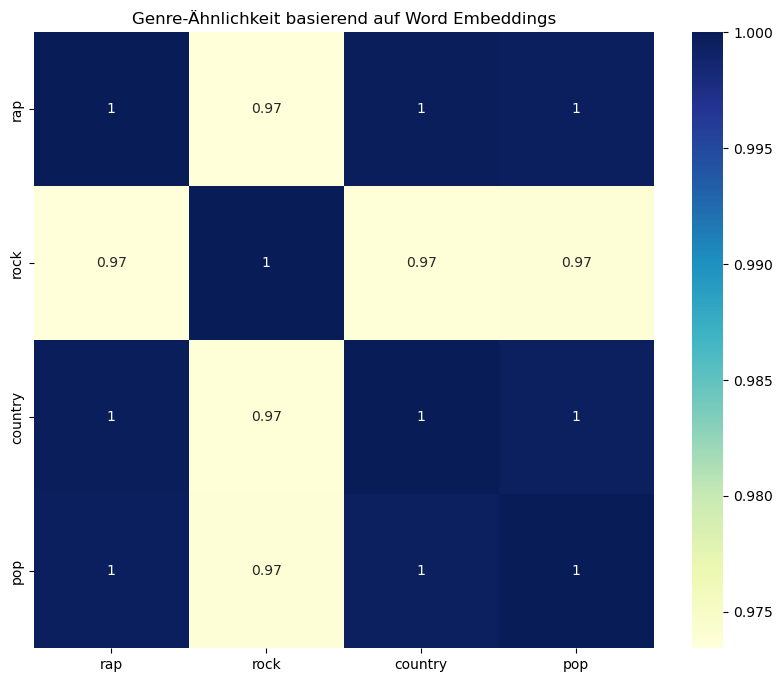

In [90]:
genres = english_sample.iloc[valid_indices]['tag'].unique()
genre_vectors = {}

for genre in genres:
    indices = songs_df[songs_df['tag'] == genre].index
    if len(indices) > 0:
        genre_vectors[genre] = np.mean(song_vectors[indices], axis=0)

genre_names = list(genre_vectors.keys())
genre_matrix = np.array([genre_vectors[g] for g in genre_names])
genre_sim = cosine_similarity(genre_matrix)

top_genres = english_sample['tag'].value_counts().head(10).index
subset_genres = [g for g in genre_names if g in top_genres]
subset_indices = [genre_names.index(g) for g in subset_genres]
sim_subset = genre_sim[np.ix_(subset_indices, subset_indices)]

plt.figure(figsize=(10, 8))
sns.heatmap(sim_subset, xticklabels=subset_genres, yticklabels=subset_genres, cmap="YlGnBu", annot=True)
plt.title('Genre-Ähnlichkeit basierend auf Word Embeddings')
plt.show()


In [91]:
def train_and_evaluate_models(sentences, example_words):
    cbow_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=0, epochs=5)
    skip_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1, epochs=5)
    
    results = {}
    for word in example_words:
        results[word] = {'cbow': [], 'skipgram': []}
        try:
            results[word]['cbow'] = cbow_model.wv.most_similar(word, topn=5)
            results[word]['skipgram'] = skip_model.wv.most_similar(word, topn=5)
        except:
            continue
    return results

results = train_and_evaluate_models(sentences, example_words[:3])

for word in results:
    print(f"\nWort: {word}")
    print("  CBOW:")
    for w, s in results[word]['cbow']:
        print(f"    {w}: {s:.4f}")
    print("  Skip-Gram:")
    for w, s in results[word]['skipgram']:
        print(f"    {w}: {s:.4f}")



Wort: love
  CBOW:
    shit: 0.6123
    verse: 0.5454
    bitch: 0.5162
    right: 0.5151
    back: 0.5111
  Skip-Gram:
    shit: 0.9974
    verse: 0.9970
    back: 0.9968
    know: 0.9967
    niggas: 0.9965

Wort: heart
  CBOW:
    one: 0.3726
    chorus: 0.3372
    used: 0.3326
    nigga: 0.3164
    got: 0.3158
  Skip-Gram:
    one: 0.9964
    verse: 0.9964
    like: 0.9963
    see: 0.9962
    get: 0.9961

Wort: money
  CBOW:
    blah: 0.5844
    niggas: 0.5645
    get: 0.5433
    pussy: 0.5308
    know: 0.5307
  Skip-Gram:
    niggas: 0.9972
    get: 0.9971
    know: 0.9970
    dont: 0.9970
    ass: 0.9969
